In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [2]:
all_30_prot=['MYH6_MOUSE','MYPC3_MOUSE','AT2A2_MOUSE','RYR2_MOUSE','MYOM1_MOUSE','ACON_MOUSE','ATPB_MOUSE','ODO1_MOUSE','ACTA_MOUSE','SPTN1_MOUSE',
'ECHA_MOUSE','ATPA_MOUSE', 'ACTN2_MOUSE','LAMA2_MOUSE','PLEC_MOUSE','OBSCN_MOUSE','PGBM_MOUSE','NNTM_MOUSE','SDHA_MOUSE','DESP_MOUSE','ECHB_MOUSE',
'SPTB2_MOUSE','ALBU_MOUSE','THIM_MOUSE','AATM_MOUSE','ACADV_MOUSE','MYG_MOUSE']

In [3]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'SARDH_MOUSE.' in x  ]    
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x and x.replace('.RateConst.csv','') in all_30_prot  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    # files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]   
    # files=[x for x in os.listdir(path) if 'SARDH_MOUSE.Quant.csv' in x  ]   
    files=[x for x in os.listdir(path) if x.replace('.Quant.csv','') in all_30_prot   ]   
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [4]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_heart"

In [5]:
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 27/27 [00:01<00:00, 14.32it/s]


In [6]:
merged=pd.merge(quant,rate,left_on=['Protein','Peptide','Charge'],right_on=['Protein','Peptides','Charge'])
merged=merged[merged['Rsquared']>0.9].reset_index(drop=True)

In [7]:
merged.RateConstants[(merged.RateConstants >= np.median(merged.RateConstants) - np.median(merged.RateConstants)*0.25) &
                  ((merged.RateConstants <= np.median(merged.RateConstants) + np.median(merged.RateConstants)*0.25))].shape[0]/merged.shape[0]

0.39656518345042935

In [8]:
# for prot in all_30_prot[1:]: 
#     tempData=merged[merged.Protein==prot]
    
#     print(tempData.shape,tempData.RateConstants)

    
#     np=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
#                     ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
#     print(prot,np)

In [9]:
# tempData=merged[merged.Protein==all_30_prot[0]]
 


# np=tempData[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
#                 ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]

In [10]:
res=[]
for prot in (all_30_prot):
    tempData=merged[merged.Protein==prot]
    if tempData.shape[0]==0: continue
    perncentage_p=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
                    ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
    print(prot,perncentage_p)
    res.append(perncentage_p)

MYH6_MOUSE 0.8905660377358491
MYPC3_MOUSE 0.8194444444444444
AT2A2_MOUSE 0.7272727272727273
RYR2_MOUSE 0.7857142857142857
MYOM1_MOUSE 0.734375
ACON_MOUSE 0.9130434782608695
ATPB_MOUSE 0.9795918367346939
ODO1_MOUSE 0.8771929824561403
ACTA_MOUSE 0.9736842105263158
SPTN1_MOUSE 0.9047619047619048
ECHA_MOUSE 0.7894736842105263
ATPA_MOUSE 0.8571428571428571
ACTN2_MOUSE 0.82
LAMA2_MOUSE 1.0
PLEC_MOUSE 0.7272727272727273
OBSCN_MOUSE 0.8571428571428571
PGBM_MOUSE 0.6666666666666666
NNTM_MOUSE 0.8709677419354839
SDHA_MOUSE 0.7428571428571429
DESP_MOUSE 0.8536585365853658
ECHB_MOUSE 0.7142857142857143
SPTB2_MOUSE 0.7586206896551724
ALBU_MOUSE 0.7884615384615384
THIM_MOUSE 0.90625
AATM_MOUSE 0.9523809523809523
ACADV_MOUSE 0.8918918918918919
MYG_MOUSE 0.9487179487179487


In [11]:
np.mean(res),np.median(res),np.std(res)

(0.8426458465597806, 0.8571428571428571, 0.08964130288223905)

In [12]:
len(res)

27

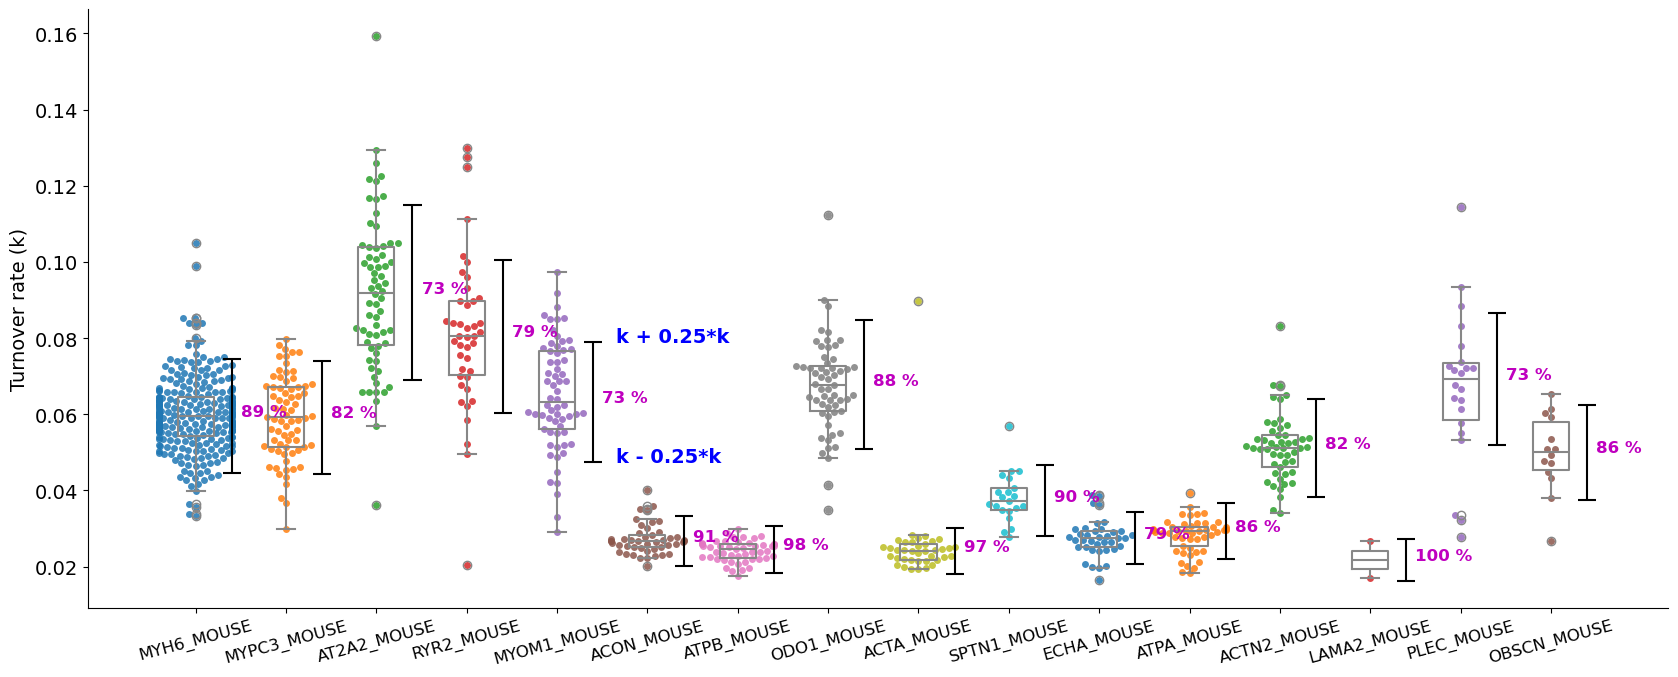

In [34]:
res=[]
plt.figure(figsize=(17,7))
plt.rc("font",size=14)
n_prot=16
for index,prot in enumerate(all_30_prot[:n_prot]):
    tempData=merged[merged.Protein==prot]
    if tempData.shape[0]==0: continue
    
    perncentage_p=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
                    ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
    sns.swarmplot(y=tempData.RateConstants,x=index,zorder=0,alpha=0.85)
    sns.boxplot(y=tempData.RateConstants,x=index,color='#878787',fill=False,width=0.4)
    # sns.boxenplot(y=tempData.RateConstants,x=index)
    
    plt.vlines(x=index+0.4,
               ymin=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,
               ymax=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,colors='k')
    plt.hlines(y=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,
               xmin=index+0.3,xmax=index+0.5,colors='k')
    plt.hlines(y=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,
               xmin=index+0.3,xmax=index+0.5,colors='k')
    plt.text(x=index+0.5,y=np.median(tempData.RateConstants),s=f"{100*perncentage_p:.0f} %",c='m',fontsize=12, fontweight='bold')
    
    if index ==4:
        plt.text(x=index+0.65,y=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,s=f"k + 0.25*k",c='blue', fontweight='bold')
        plt.text(x=index+0.65,y=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,s=f"k - 0.25*k",c='blue', fontweight='bold')
        
    
    # print(prot,perncentage_p)
    res.append(perncentage_p)
    
    if index ==n_prot: break

plt.xticks( range(n_prot), all_30_prot[:n_prot],rotation=15,fontsize=12)    
# plt.show()
np.mean(res),np.median(res),np.std(res)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Turnover rate (k)")

plt.tight_layout()
plt.savefig("rate_percentage_heart.jpeg",dpi=900)

In [35]:
np.mean(res),np.median(res),np.std(res)

(0.8535424396047624, 0.8571428571428571, 0.0855037763888304)